# Классификация токсичности текстов для интернет-магазина

***Постановка задачи:***

Ускорить модерацию комментариев в интернет-магазине, автоматизировав оценку их токсичности.

Обучить модель классифицировать комментарии на позитивные и негативные.

Необходимо добиться значение метрики качества F1 не менее 0.75.

***Входные данные:*** набор данных с разметкой о токсичности правок.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-предпросмотр-данных" data-toc-modified-id="Загрузка-и-предпросмотр-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка и предпросмотр данных</a></span></li><li><span><a href="#Очистка,-токенизация-и-лемматизация-текста" data-toc-modified-id="Очистка,-токенизация-и-лемматизация-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка, токенизация и лемматизация текста</a></span></li><li><span><a href="#Деление-на-тестовую-и-обучающие-выборки." data-toc-modified-id="Деление-на-тестовую-и-обучающие-выборки.-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Деление на тестовую и обучающие выборки.</a></span></li><li><span><a href="#Визуализация-мешков-слов-для-положительного-и-отрицательного-признака" data-toc-modified-id="Визуализация-мешков-слов-для-положительного-и-отрицательного-признака-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Визуализация мешков слов для положительного и отрицательного признака</a></span></li><li><span><a href="#Создание-векторизированных-признаком-TF-IDF" data-toc-modified-id="Создание-векторизированных-признаком-TF-IDF-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Создание векторизированных признаком TF-IDF</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Подготовка данных

### Загрузка и предпросмотр данных

In [1]:
!pip install lightgbm

In [2]:
!pip install wordcloud

In [3]:
import pandas as pd 
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import re
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import SCORERS
from lightgbm import LGBMClassifier
import time
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\v_kly\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\v_kly\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\v_kly\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
path = 'C:/users/v_kly'

In [8]:
df = pd.read_csv(path + '/datasets/toxic_comments.csv')

In [9]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [11]:
df.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Присутствует дисбаланс классов.

### Очистка, токенизация и лемматизация текста

С помощью регулярных выражений очистим текст от лишних символов.

In [12]:
%%time
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))

Wall time: 3.09 s


Создадим класс для лемматизации:

In [13]:
lemmatizer = WordNetLemmatizer()

Напишем функцию, которая произведет токенизацию и лемматизацию данных:

In [14]:
def lemmatize(data):
    result = []
    for i in range(len(data)):
        tokenized = nltk.word_tokenize(data[i])
        result.append(" ".join([lemmatizer.lemmatize(w) for w in tokenized]))
    return result

In [15]:
%%time
df['text'] = lemmatize(df['text'])

Wall time: 1min 12s


### Деление на тестовую и обучающие выборки.

In [16]:
features = df.text
target = df.toxic

In [17]:
train_features, test_features, train_target, test_target = train_test_split(
    features, target, test_size=0.2, stratify=target)

Проверим корректность разделения и стратификации.

In [18]:
print(train_features.shape)
print(test_features.shape)
print(train_target.shape)
print(test_target.shape)

(127656,)
(31915,)
(127656,)
(31915,)


In [19]:
round(train_target.mean(), 5) == round(test_target.mean(), 5)

True

### Визуализация мешков слов для положительного и отрицательного признака

Функция визуализации:

In [20]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off")

Создание наборов слов:

In [21]:
text_down = ' '.join(df['text'].loc[df.toxic == 1].values)
text_up = ' '.join(df['text'].loc[df.toxic == 0].values)

Создание масок для визуализации:

In [22]:
mask_up = np.array(Image.open(path + '/datasets/upvote.jpg'))
mask_down = np.array(Image.open(path + '/datasets/downvote.jpg'))

Вывод изображения с заданными параметрами:

In [23]:
wordcloud_up = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='navy', colormap='rainbow', collocations=False, 
                      stopwords = STOPWORDS, mask=mask_up).generate(text_up)

In [24]:
wordcloud_down = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='navy', colormap='rainbow', collocations=False, 
                      stopwords = STOPWORDS, mask=mask_down).generate(text_down)

**ОБЛАКО СЛОВ ПОЛОЖИТЕЛЬНОГО КЛАССА**

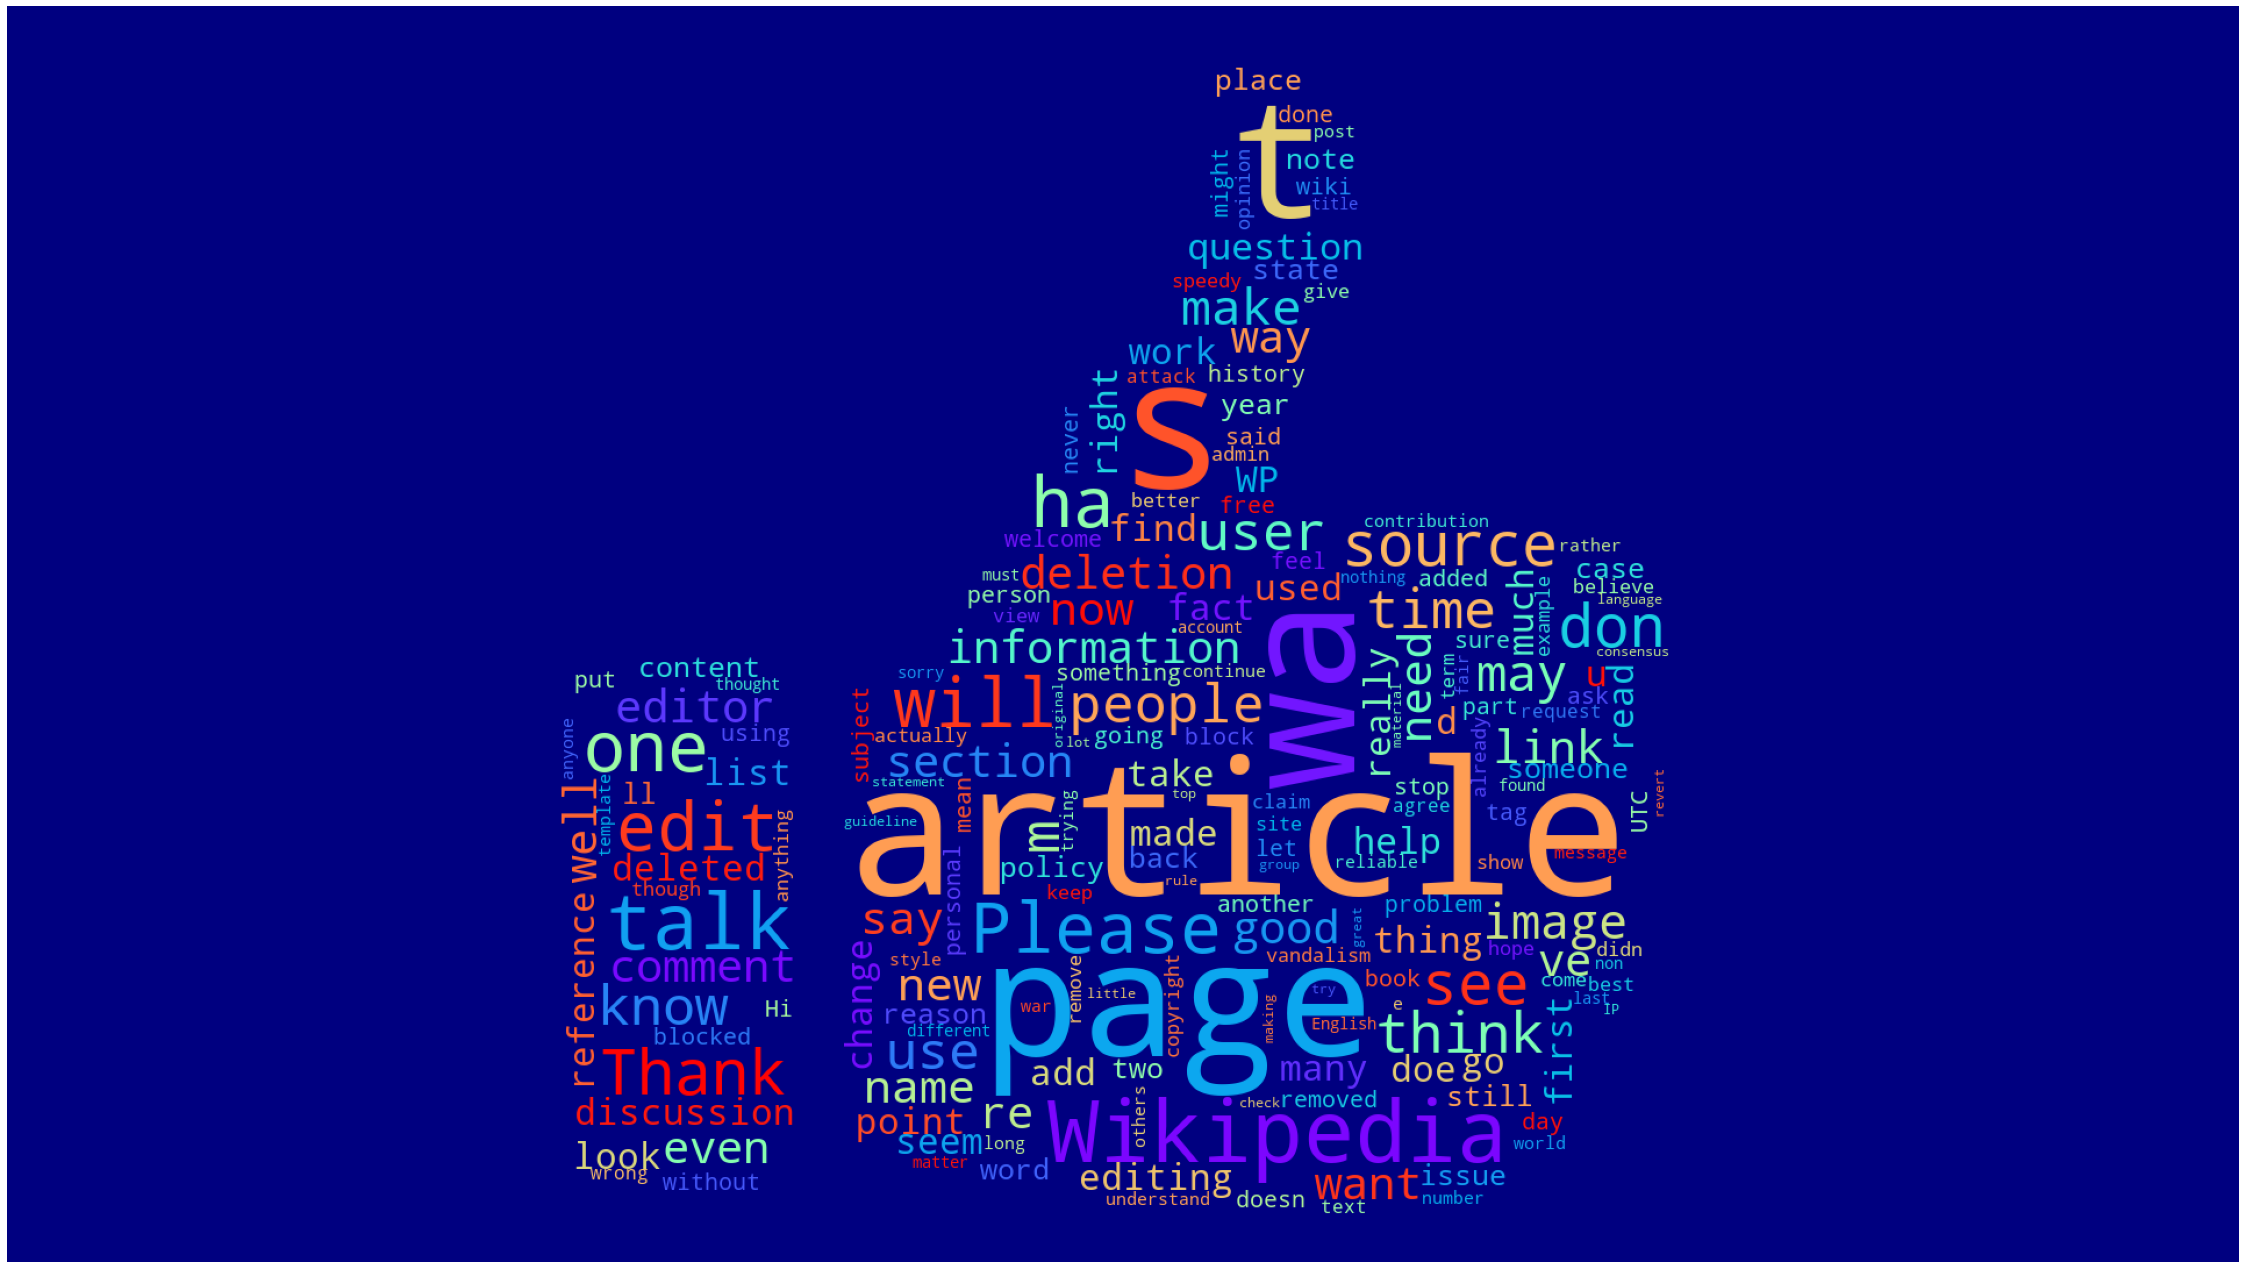

In [25]:
plot_cloud(wordcloud_up)

**ОБЛАКО СЛОВ ТОКСИЧНОГО КЛАССА**

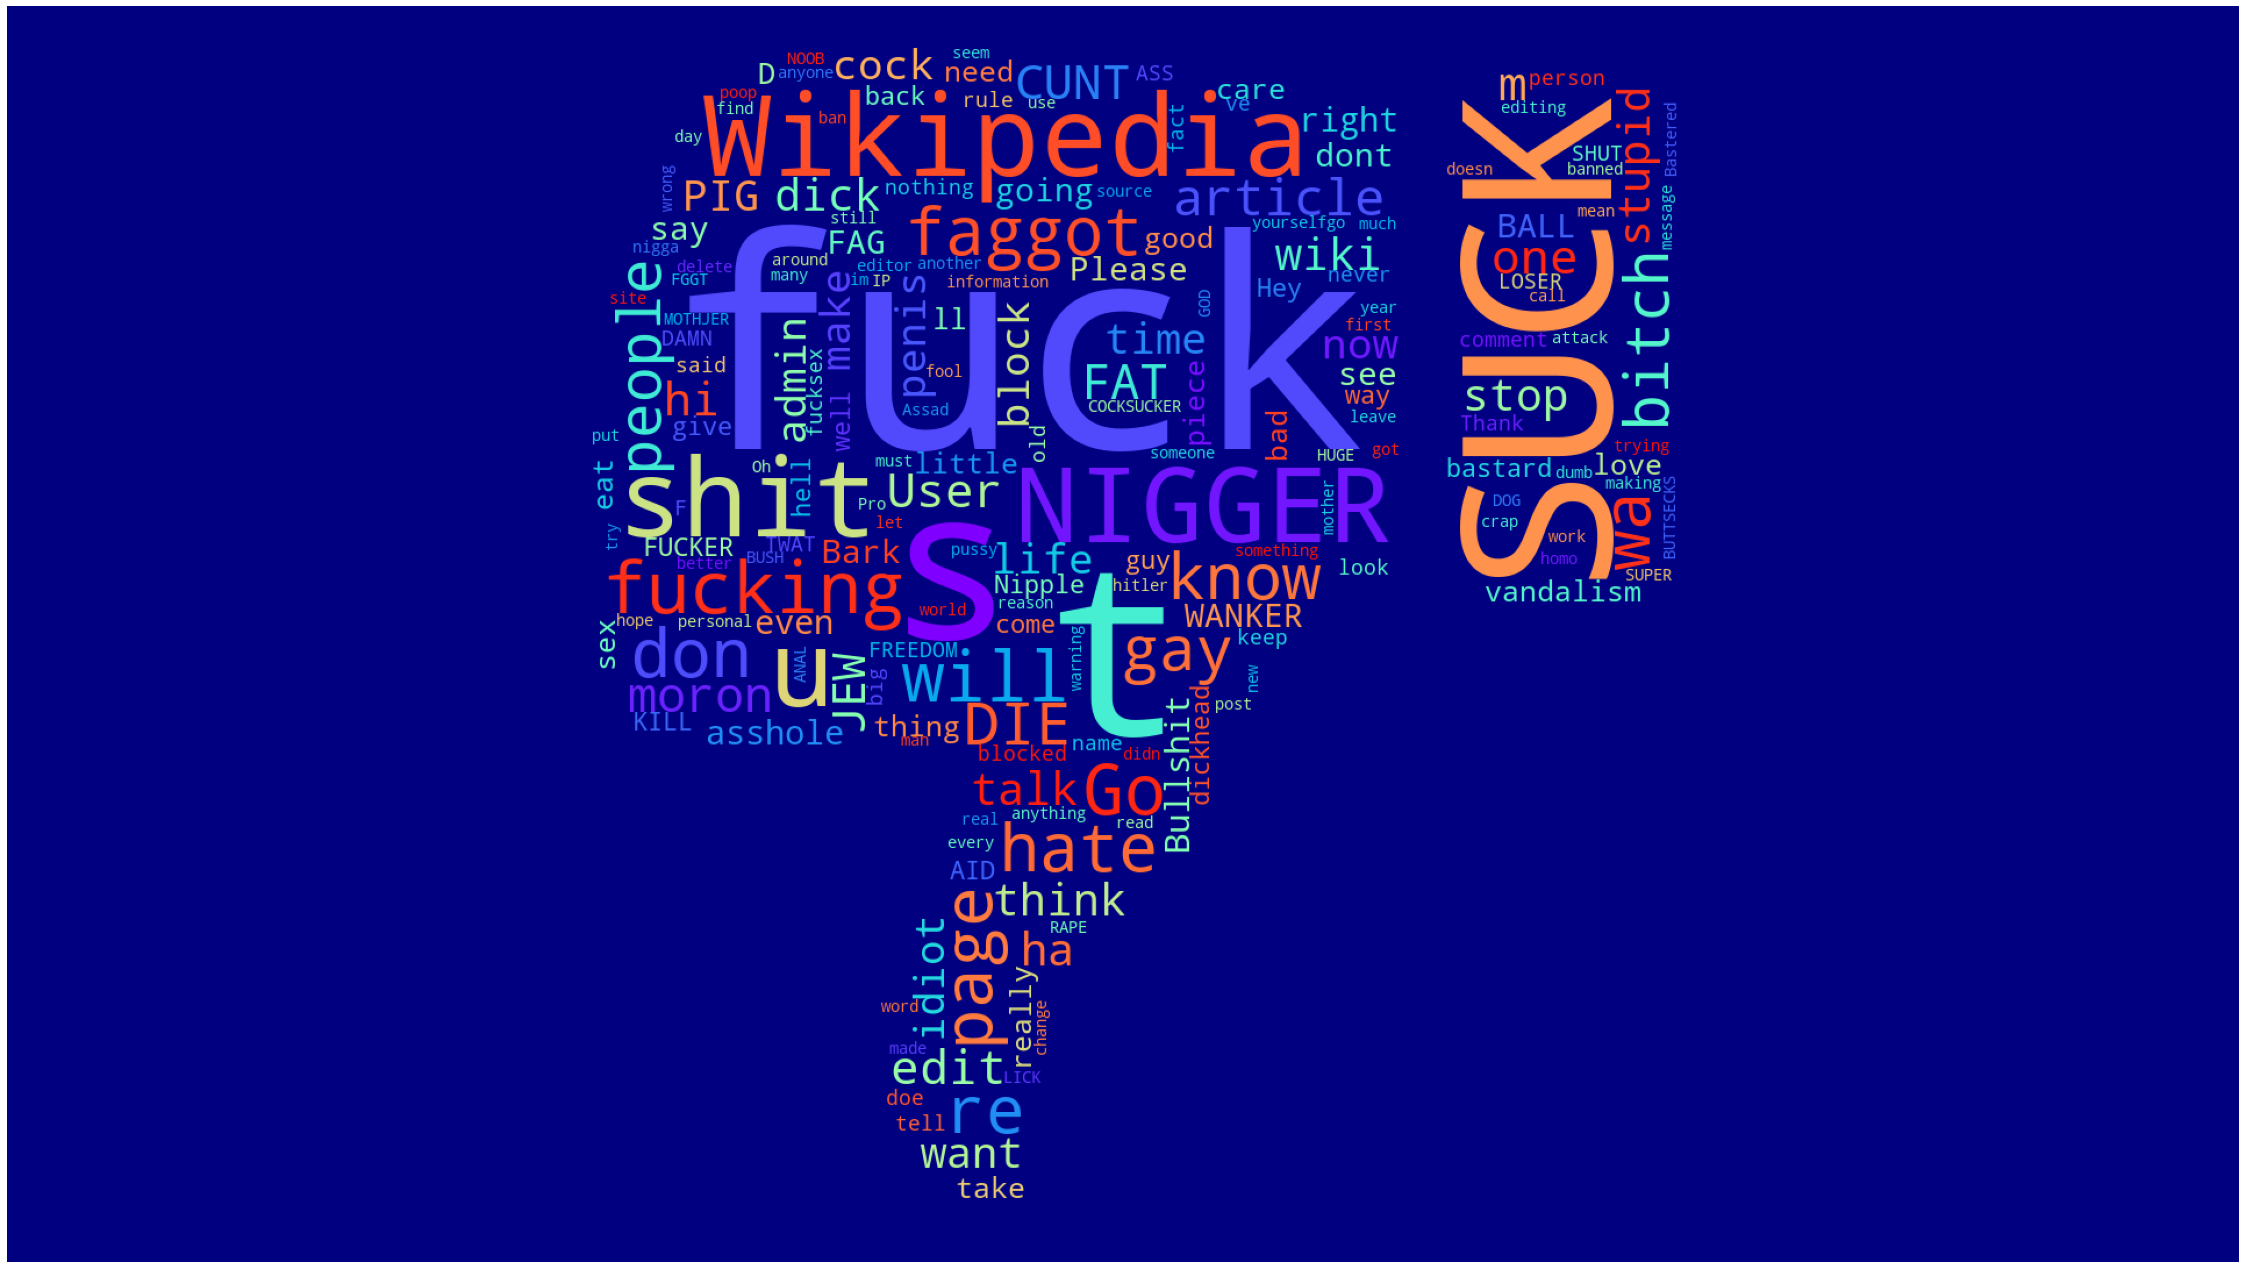

In [26]:
plot_cloud(wordcloud_down)

### Создание векторизированных признаком TF-IDF

Создадим счетчик TF-IDF и укажем в нем стоп-слова

In [27]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Создадим корпус слов для обучения

In [28]:
%%time
corpus = train_features.values

Wall time: 0 ns


Обучим и трансформируем признаки

In [29]:
%%time
tf_idf = count_tf_idf.fit_transform(corpus) 

Wall time: 5.62 s


Трансформируем признаки для тестовой выборки

In [30]:
%%time
corpus_test = test_features.values

Wall time: 0 ns


In [31]:
%%time
tf_idf_test = count_tf_idf.transform(corpus_test)

Wall time: 1.32 s


## Обучение моделей

### Логистическая регрессия

Обучим логистическую регрессию со встроенной кросс-валидацией:

In [32]:
model_logistic = LogisticRegressionCV(
    cv=3, n_jobs=-1, scoring='f1', 
    solver='liblinear', class_weight='balanced')

In [33]:
startTime = time.time() 

model_logistic.fit(tf_idf, train_target)

endTime = time.time()
log_train_time = endTime - startTime


In [34]:
startTime = time.time() 

predictions = model_logistic.predict(tf_idf_test)
logistic_f1 = f1_score(test_target, predictions)

endTime = time.time()
log_pred_time = endTime - startTime

logistic_f1


0.7551347414420977

In [35]:
print('Результаты работы модели Логистической Регрессии')
pd.DataFrame({
    "Model" : 'LogisticRegressionCV',
    "F-1" : [logistic_f1],
    "Время обучения(sec)" : [log_train_time],
    "Время предсказания(sec)" : [log_pred_time]
})

Результаты работы модели Логистической Регрессии


,Model,F-1,Время обучения(sec),Время предсказания(sec)
0,LogisticRegressionCV,0.755135,58.612005,0.014542


### LGBM

**Используем метод GreadSearceCV с внутренней кросс-валидацией.**

In [36]:
lgbm = LGBMClassifier(class_weight = 'balanced')

In [37]:
parameters = {'n_estimators': (10, 50, 100, 500)}

In [38]:
grid_lgbm = GridSearchCV(
    estimator = lgbm, param_grid = parameters, 
    scoring = 'f1', n_jobs = -1, cv=3)

In [39]:
%%time
grid_lgbm.fit(tf_idf, train_target)

Wall time: 5min 41s


GridSearchCV(cv=3, estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'n_estimators': (10, 50, 100, 500)}, scoring='f1')

In [40]:
startTime = time.time()

pred = grid_lgbm.predict(tf_idf_test)

endTime = time.time()
totalTimePred_lgbm = endTime - startTime

lgbm_f1 = f1_score(test_target, pred)
lgbm_f1

0.7628105039034776

In [41]:
print('Результаты работы модели LGBM')
pd.DataFrame({
    "Model" : 'LGBMClassifier',
    "F-1" : [lgbm_f1],
    "Время обучения(sec)" : [grid_lgbm.refit_time_],
    "Время предсказания(sec)" : [totalTimePred_lgbm]
})

Результаты работы модели LGBM


,Model,F-1,Время обучения(sec),Время предсказания(sec)
0,LGBMClassifier,0.762811,108.474361,0.640787


### RandomForestClassifier

**Используем метод GreadSearceCV с внутренней кросс-валидацией.**

In [42]:
rfc = RandomForestClassifier(class_weight='balanced')

In [43]:
parameters = {'n_estimators': range(200, 220, 10), 'max_depth': range(30, 36, 3)}

In [44]:
grid_rfc = GridSearchCV(
    estimator = rfc, param_grid = parameters, 
    scoring = 'f1', n_jobs = -1, cv=3)

In [45]:
%%time
grid_rfc.fit(tf_idf, train_target)

Wall time: 4min 57s


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': range(30, 36, 3),
                         'n_estimators': range(200, 220, 10)},
             scoring='f1')

In [46]:
grid_rfc.best_params_

{'max_depth': 33, 'n_estimators': 210}

In [47]:
startTime = time.time()

pred = grid_rfc.predict(tf_idf_test)

endTime = time.time()
totalTimePred_rfc = endTime - startTime

rfc_f1 = f1_score(test_target, pred)
rfc_f1

0.4406133443845835

In [48]:
print('Результаты работы модели Случайного Леса')
pd.DataFrame({
    "Model" : 'RandomForestClassifier',
    "F-1" : [rfc_f1],
    "Время обучения(sec)" : [grid_rfc.refit_time_],
    "Время предсказания(sec)" : [totalTimePred_rfc]
})

Результаты работы модели Случайного Леса


,Model,F-1,Время обучения(sec),Время предсказания(sec)
0,RandomForestClassifier,0.440613,52.180282,1.408538


## Выводы

Сведём итоговые результаты в единую таблицу:

In [49]:
print('Результаты работы модели Логистической Регрессии')
pd.DataFrame({
    "Model" : ['LogisticRegressionCV','LGBMClassifier', 'RandomForestClassifier'],
    "F-1" : [logistic_f1, lgbm_f1, rfc_f1],
    "Время обучения(sec)" : [log_train_time, grid_lgbm.refit_time_, grid_rfc.refit_time_],
    "Время предсказания(sec)" : [log_pred_time, totalTimePred_lgbm, totalTimePred_rfc]
})

Результаты работы модели Логистической Регрессии


,Model,F-1,Время обучения(sec),Время предсказания(sec)
0,LogisticRegressionCV,0.755135,58.612005,0.014542
1,LGBMClassifier,0.762811,108.474361,0.640787
2,RandomForestClassifier,0.440613,52.180282,1.408538


Как видно из таблицы выше по значению ключевой метрики с задачей справились модели LogisticRegressionCV и LGBMClassifier. Лучший результат у модели LGBMClassifier.

При этом скорость обучения выше у модели LogisticRegressionCV, что делает ее фаворитом в случае работы с большими массивами.

Вместе с тем, скорость предсказаний более чем в 200 раз лучше у модели LogisticRegressionCV, что позволяет ее использовать уже в обученном виде для высоконагруженной постоянной предиктивной работы.